# Video pipeline with Yolo + Resnet Model

In [12]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import (
    draw_temporal_final,
    draw_cumulative,
    draw_temporal_final2,
)
import experiments.utils.drawing

In [13]:
BURSTY = "Bursty"
STEADY_LOW = "Steady Low"
STEADY_HIGH = "Steady High"
FLUCTUATING = "Fluctuating"

series_load_type = {
    4000: BURSTY,
    4001: BURSTY,
    4002: BURSTY,
    4003: BURSTY,
    4004: BURSTY,
    4005: STEADY_LOW,
    4006: STEADY_LOW,
    4007: STEADY_LOW,
    4008: STEADY_LOW,
    4009: STEADY_LOW,
    4010: STEADY_HIGH,
    4011: STEADY_HIGH,
    4012: STEADY_HIGH,
    4013: STEADY_HIGH,
    4014: STEADY_HIGH,
    4015: FLUCTUATING,
    4016: FLUCTUATING,
    4017: FLUCTUATING,
    4018: FLUCTUATING,
    4019: FLUCTUATING,
}
series_names = {
    4000: "IPA",
    4001: "FA2-low",
    4002: "FA2-high",
    4003: "RIM-low",
    4004: "RIM-high",
    4005: "IPA",
    4006: "FA2-low",
    4007: "FA2-high",
    4008: "RIM-low",
    4009: "RIM-high",
    4010: "IPA",
    4011: "FA2-low",
    4012: "FA2-high",
    4013: "RIM-low",
    4014: "RIM-high",
    4015: "IPA",
    4016: "FA2-low",
    4017: "FA2-high",
    4018: "RIM-low",
    4019: "RIM-high",
}

load_series = {BURSTY: [], STEADY_LOW: [], STEADY_HIGH: [], FLUCTUATING: []}
for serie, load_type in series_load_type.items():
    load_series[load_type].append(serie)

pipeline_name = "video-batch"
series_paths = {
    series: os.path.join(FINAL_RESULTS_PATH, "series", str(series))
    for series in series_names.keys()
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1615175/991522401.py", line 61, in <module>
    loaders = {
  File "/tmp/ipykernel_1615175/991522401.py", line 62, in <dictcomp>
    series: AdaptationParser(
  File "/home/cc/infernece-pipeline-joint-optimization/experiments/utils/parser.py", line 529, in __init__
    self.loader = Parser(
  File "/home/cc/infernece-pipeline-joint-optimization/experiments/utils/parser.py", line 40, in __init__
    list(self.load_configs().values())[0]["nodes"],
  File "/home/cc/infernece-pipeline-joint-optimization/experiments/utils/parser.py", line 46, in load_configs
    for file in os.listdir(self.series_path):
FileNotFoundError: [Errno 2] No such file or directory: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/series/4000'

During handling of

In [14]:
loaders

{400: <experiments.utils.parser.AdaptationParser at 0x7fe64c9a2820>,
 401: <experiments.utils.parser.AdaptationParser at 0x7fe71856efd0>,
 402: <experiments.utils.parser.AdaptationParser at 0x7fe7185e1700>,
 403: <experiments.utils.parser.AdaptationParser at 0x7fe6562cb190>,
 404: <experiments.utils.parser.AdaptationParser at 0x7fe7185e1970>,
 405: <experiments.utils.parser.AdaptationParser at 0x7fe71ce2f910>,
 406: <experiments.utils.parser.AdaptationParser at 0x7fe71ce3a760>,
 407: <experiments.utils.parser.AdaptationParser at 0x7fe64c9a2d30>,
 408: <experiments.utils.parser.AdaptationParser at 0x7fe64c6d11f0>,
 409: <experiments.utils.parser.AdaptationParser at 0x7fe64c6d1280>,
 410: <experiments.utils.parser.AdaptationParser at 0x7fe64c6d1220>,
 411: <experiments.utils.parser.AdaptationParser at 0x7fe7185f3b50>,
 412: <experiments.utils.parser.AdaptationParser at 0x7fe7185f34c0>,
 413: <experiments.utils.parser.AdaptationParser at 0x7fe7185f3df0>,
 414: <experiments.utils.parser.Ad

In [15]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 400 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 2,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10,
    'gamma': 10,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'logs_enabled': False,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                     'memory_request': '

In [16]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [17]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{400: False,
 401: False,
 402: False,
 403: False,
 404: False,
 405: False,
 406: False,
 407: False,
 408: False,
 409: False,
 410: False,
 411: False,
 412: False,
 413: False,
 414: False,
 415: False,
 416: False,
 417: False,
 418: False,
 419: False}

In [18]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [19]:
series_changes = {}
for series in series_names.keys():
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1615175/2578029705.py", line 3, in <module>
    series_changes[series] = loaders[series].series_changes(
KeyError: 4000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structured_traceback(
  Fil

## Comparing Predicted Load with the Recieved Load

In [20]:
first_sereis = list(series_changes.keys())[
    0
]  # load should be roughly similar among the series
recieved_load = series_changes[first_sereis]["recieved_load"]
recieved_load_x = [x for x in range(0, len(recieved_load))]
predicted_load = series_changes[first_sereis]["predicted_load"]
predicted_load_x = series_changes[first_sereis]["time_interval"]
sent_load = sent_loads[first_sereis]
sent_load_x = [x for x in range(0, len(sent_loads[first_sereis]))]


plt.figure(figsize=(5, 2))
plt.plot(recieved_load_x, recieved_load, label="recieved_load")
plt.plot(sent_load_x, sent_load, label="sent_load")
plt.plot(predicted_load_x, predicted_load, label="predicted_load")
# TODO add predicted reference load here
plt.legend()
plt.show()

IndexError: list index out of range

In [ ]:
final_dict = {}
METRIC_TOTAL_CORE_CHANGES = "total_core_changes"
METRIC_ACCURACY_CHANGES = "accuracy_changes"
METRIC_MEASURED_LATENCY = "measured_latency"
METRIC_TIMEOUT_DICS = "timeout_dics"
METRICS = [
    METRIC_TOTAL_CORE_CHANGES,
    METRIC_ACCURACY_CHANGES,
    METRIC_MEASURED_LATENCY,
    METRIC_TIMEOUT_DICS,
]

final_dict["replica_changes"] = {}
final_dict["core_changes"] = {}
final_dict[METRIC_TOTAL_CORE_CHANGES] = {}
final_dict[METRIC_ACCURACY_CHANGES] = {}
final_dict[METRIC_MEASURED_LATENCY] = {}
final_dict[METRIC_TIMEOUT_DICS] = {}

latency_metric = "p99"  # [min, max, p99]


final_by_load_type = {BURSTY: {}, STEADY_LOW: {}, STEADY_HIGH: {}, FLUCTUATING: {}}
for k in final_by_load_type:
    for m in METRICS:
        final_by_load_type[k][m] = {}


for series, series_dict in series_changes.items():
    final_dict["replica_changes"][series] = {}
    final_dict["core_changes"][series] = {}
    final_dict[METRIC_TOTAL_CORE_CHANGES][series] = {}
    final_dict[METRIC_ACCURACY_CHANGES][series] = {}

    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["replica_changes"][series][node_name] = metrics["replicas"]
        final_dict["core_changes"][series][node_name] = metrics["cpu"]
        final_dict[METRIC_ACCURACY_CHANGES][series][node_name] = metrics["accuracy"]

    timeout_per_second, per_second_results = loaders[
        series
    ].per_second_result_processing()

    metric_columns = list(
        filter(lambda col: latency_metric in col, per_second_results.columns)
    )
    final_dict[METRIC_MEASURED_LATENCY][series] = per_second_results[
        metric_columns
    ].to_dict(orient="list")

    final_dict[METRIC_TIMEOUT_DICS][series] = {"timeout_per_second": timeout_per_second}

    # totals
    final_dict["replica_changes"][series]["total"] = [
        sum(x) for x in zip(*final_dict["replica_changes"][series].values())
    ]
    final_dict["core_changes"][series]["total"] = [
        sum(x) for x in zip(*final_dict["core_changes"][series].values())
    ]
    if accuracy_methods[series] == "sum":
        final_dict[METRIC_ACCURACY_CHANGES][series]["e2e"] = [
            sum(x) for x in zip(*final_dict["accuracy_changes"][series].values())
        ]

    for key in final_dict["replica_changes"][series].keys():
        final_dict[METRIC_TOTAL_CORE_CHANGES][series][key] = [
            x * y
            for x, y in zip(
                final_dict["replica_changes"][series][key],
                final_dict["core_changes"][series][key],
            )
        ]


del final_dict["replica_changes"]
del final_dict["core_changes"]


for metric in METRICS:
    for serie in final_dict[metric].keys():
        final_by_load_type[series_load_type[serie]][metric][
            series_names[serie]
        ] = final_dict[metric][serie]

num_works = 5


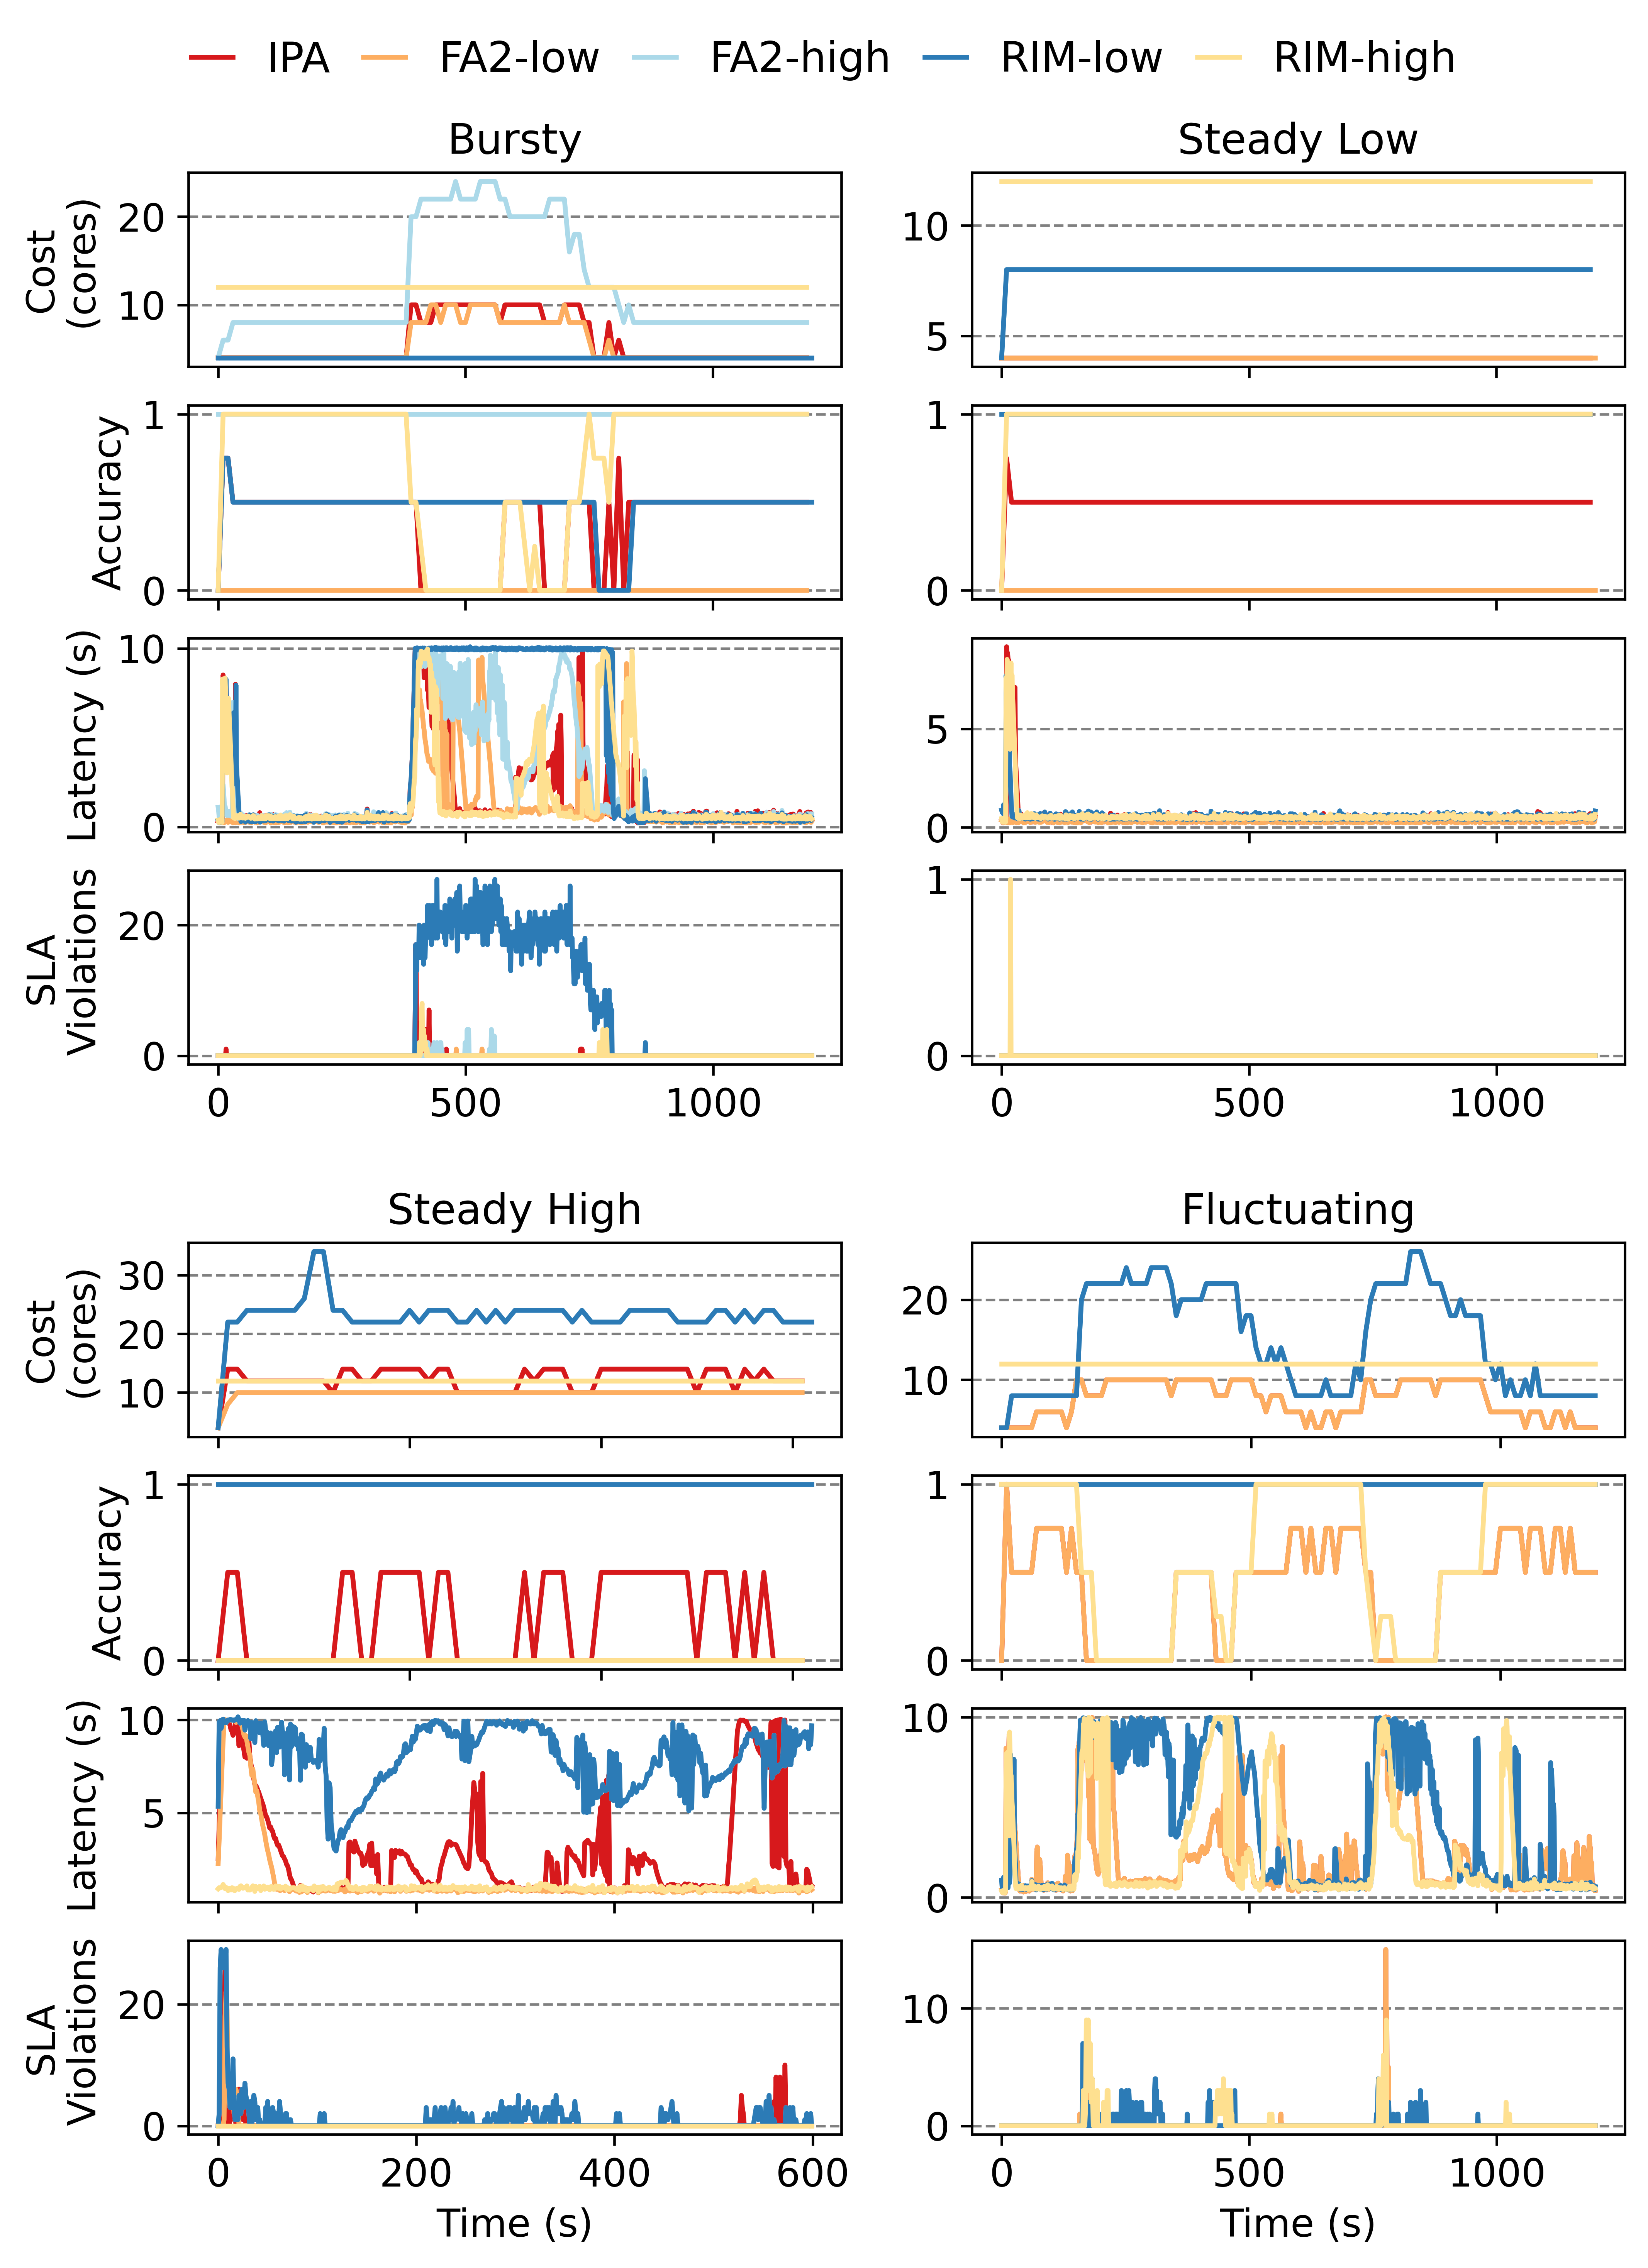

In [ ]:
import importlib

importlib.reload(experiments.utils.drawing)
selected_experiments = {
    METRIC_TOTAL_CORE_CHANGES: {
        "selection": ["total"],
        "title": "Cost",
        "ylabel": "Cost\n (cores)",
    },
    METRIC_ACCURACY_CHANGES: {
        "selection": ["e2e"],
        "title": "Accuracy",
        "ylabel": "Accuracy",
    },
    METRIC_MEASURED_LATENCY: {
        "selection": [f"e2e_{latency_metric}"],
        "title": "Latency",
        "ylabel": "Latency (s)",
    },
    METRIC_TIMEOUT_DICS: {
        "selection": [f"timeout_per_second"],
        "title": "SLA Violations",
        "ylabel": "SLA\n Violations",
    },
}
experiments.utils.drawing.draw_temporal_final3(
    final_by_load_type,
    adaptation_interval=adaptation_intervals,
    selected_experiments=selected_experiments,
    bbox_to_anchor=(0.8, 11),
    save=True,
    filename=f"./figures/{pipeline_name}.pdf",
)